# Greenest Pixel Covariates

Using the Greenest Pixel stack of bands, calculate varies covariates: TCB, TCG, TCW, SAVI (MSAVI?), NDMI, NBR, NBR2

In [ ]:
# DEPRECATED

#!pip install geopandas
#!pip install rio-cogeo

In [1]:
import json
import os
import rasterio as rio
import geopandas as gpd
from shapely.geometry import box
from fiona.crs import from_epsg
from rasterio.mask import mask
import numpy as np
import matplotlib.pyplot as plt

import os
import tarfile
import rasterio

from rasterio.io import MemoryFile
from rasterio.transform import from_bounds

from rio_cogeo.cogeo import cog_translate
from rio_cogeo.profiles import cog_profiles


/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
# FUNCTION TO READ IN BANDS FROM EXISTING IMAGE

infile = '/projects/bobafett/LandsatComposites/LandsatComposites/Landsat8_40349_comp.tif'

def ReadInBand(file, band):
    with rio.open(file, 'r') as f:
        global crs
        crs = f.crs
        global transform
        transform = f.transform
        Arr = f.read(band)
        
    return np.ma.masked_array(Arr.astype(np.float32()), mask=f.nodata)

In [3]:
# Co-var functions
# Reads in bands on the fly, as needed

# SAVI
def calcSAVI(red, nir):
    savi = ((nir - red)/(nir + red + 0.5))*(1.5)
    print('SAVI Created')
    return savi

# MASAVI
def calcMSAVI(red, nir):
    msavi = (2 * nir + 1 - np.sqrt((2 * nir + 1)**2 - 8 * (nir - red))) / 2
    print('MSAVI Created')
    return msavi

# NDMI
def calcNDMI(nir, swir):
    ndmi = (nir - swir)/(nir + swir)
    print('NDMI Created')
    return ndmi

# EVI
def calcEVI(blue, red, nir):
    evi = 2.5 * ((nir - red) / (nir + 6 * red - 7.5 * blue + 1))
    print('EVI Created')
    return evi

# NBR
def calcNBR(nir, swir2):
    nbr = (nir - swir2)/(nir + swir2)
    print('NBR Created')
    return nbr

# NBR2
def calcNBR2(swir, swir2):    
    nbr2 = (swir - swir2)/(swir + swir2)
    print('NBR2 Created')
    return nbr2

# Tasseled Cap
tc_coef = [
    (0.3029, 0.2786, 0.4733, 0.5599, 0.5080, 0.1872), #brightness
    (-0.2941, -0.2430, -0.5424, 0.7276, 0.0713, -0.1608), #greenness
    (0.1511, 0.1973, 0.3283, 0.3407, -0.7117, -0.4559) #wetness
    ]

def tasseled_cap(bands, tc_coef):
    '''
    Compute the tasseled cap indices: brightness, greenness, wetness
    bands - a 6-layer 3-D (images) or 2-D array (samples) or an OrderedDict with appropriate band names
    tc_coef - a list of 3 tuples, each with 6 coefficients
    '''
    in_arr = ReadInBand(infile, bands).astype(np.float)
    
    #print(np.max(in_arr))
    if np.shape(in_arr)[0] != 5: # must have 6 bands - insert SWIR2
        raise ValueError("Input array must have 6 bands")
    
    if len(np.shape(in_arr)) == 3:
        tc = np.zeros( (3, in_arr.shape[1], in_arr.shape[2]), dtype = np.float32() )
    elif len(np.shape(in_arr)) == 2:
        tc = np.zeros( (2, in_arr.shape[1]), dtype = np.float32() )
    else:
        print('BANDS SHAPE ERROR')
    
    for i, t in enumerate(tc_coef):
        for b in range(5): # should be 6
            tc[i] += (in_arr[b] * t[b]).astype(np.float32())
           
    print('TC Created')
    return tc[0], tc[1], tc[2] 
    

In [4]:
# This takes the NumPy array and writes it to a COG with good compression 

# Specify GeoTIFF structure
def write_cog(stack, infile):
    # Get the rio-cogeo profile for deflate compression, modify some of the options
    dst_profile = cog_profiles.get("deflate")
    dst_profile['blockxsize']=256
    dst_profile['blockysize']=256
    dst_profile['predictor']=2
    dst_profile['zlevel']=7
    print('dst_profile = ', dst_profile)

    src_profile = dict(
        driver="GTiff",
        height=stack.shape[1],
        width=stack.shape[2],
        count=stack.shape[0],
        dtype=stack.dtype,
        crs=crs,
        transform=transform,
        nodata=np.nan)
    print('src_profile = ', src_profile)

    with MemoryFile() as memfile:
        with memfile.open(**src_profile) as mem:        
            # Populate the input file with NumPy array
            mem.write(stack)
            print('write imgf to memory')
        
            cog_translate(
                mem,
                # To avoid rewriting over the infile
                infile.replace('.tif','_cog.tif'),
                dst_profile,
                in_memory=True,
                quiet=True)
    
    print('Image written to disk')

In [5]:
# Read bands and calculate indices
Blue = ReadInBand(infile, 1)
Green = ReadInBand(infile, 2)
Red = ReadInBand(infile, 3)
NIR = ReadInBand(infile, 4)
SWIR = ReadInBand(infile, 5)
NDVI = ReadInBand(infile, 6)

# reads bands on the fly

SAVI = calcSAVI(Red, NIR)

MSAVI = calcMSAVI(Red, NIR)

NDMI = calcNDMI(NIR, SWIR)

EVI = calcEVI(Blue, Red, NIR)

NBR = calcNBR(NIR, NDVI) # should be NIR, SWIR2

NBR2 = calcNBR2(SWIR, NDVI) # should be SWIR, SWIR2

TCB, TCG, TCW = tasseled_cap([1,2,3,4,5],tc_coef)



SAVI Created
MSAVI Created
NDMI Created
EVI Created
NBR Created
NBR2 Created
TC Created


In [6]:
stack = np.transpose([Blue, Green, Red, NIR, SWIR, NDVI, SAVI, MSAVI, NDMI, EVI, NBR, NBR2, TCB, TCG, TCW], [0, 1, 2]) 
print(np.shape(stack))

(15, 1114, 708)


In [7]:
write_cog(stack, infile)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
Reading input: <open DatasetWriter name='/vsimem/a356aca3-16c5-42c2-84b9-7596b88bcd8e/a356aca3-16c5-42c2-84b9-7596b88bcd8e.tif' mode='w+'>


dst_profile =  {'driver': 'GTiff', 'interleave': 'pixel', 'tiled': True, 'blockxsize': 256, 'blockysize': 256, 'compress': 'DEFLATE', 'predictor': 2, 'zlevel': 7}
dst_profile =  {'driver': 'GTiff', 'height': 1114, 'width': 708, 'count': 15, 'dtype': dtype('float32'), 'crs': CRS.from_epsg(32611), 'transform': Affine(30.0, 0.0, 478768.65756464977,
       0.0, -30.0, 5638747.466976735), 'nodata': nan}
write band to memory


Adding overviews...
Updating dataset tags...
Writing output to: /projects/bobafett/LandsatComposites/LandsatComposites/Landsat8_40349_comp_cog.tif


band written to image


In [20]:
# Non-COG
# Function to append the band to existing image

def Add_Band_to_Stack(band, bandnum):
    kwargs=({'driver':'GTiff',
             'height':band.shape[0],
             'width':band.shape[1],
             'dtype':band.dtype,
             'crs':crs,
             'count':bandnum,
             'transform':transform,
             'compress':'deflate'
            })
        # tmp to avoid unning 3.1.2 again
    outfile = infile.replace('.tif','_copy.tif')
    with rio.open(outfile, 'w+', **kwargs) as dst:
        dst.write_band(bandnum, band)

In [9]:
# Add bands to the existing stack
# Calculates Index on the fly to not store in memory

Add_Band_to_Stack(calcSAVI(), 7)
Add_Band_to_Stack(calcMSAVI(), 8)
Add_Band_to_Stack(calcNDMI(), 9)
Add_Band_to_Stack(calcEVI(), 10)
Add_Band_to_Stack(calcNBR(), 11)
Add_Band_to_Stack(calcNBR2(), 12)
Add_Band_to_Stack(tasseled_cap([1,2,3,4,5],tc_coef)[0], 13)
Add_Band_to_Stack(tasseled_cap([1,2,3,4,5],tc_coef)[1], 14)
Add_Band_to_Stack(tasseled_cap([1,2,3,4,5],tc_coef)[2], 15)

In [5]:
# calculate indices for checking

SAVI = calcSAVI()
MSAVI = calcMSAVI()
NDMI = calcNDMI()
EVI = calcEVI()
NBR = calcNBR()
NBR2 = calcNBR2()

tc_coef = [
    (0.3029, 0.2786, 0.4733, 0.5599, 0.5080, 0.1872), #brightness
    (-0.2941, -0.2430, -0.5424, 0.7276, 0.0713, -0.1608), #greenness
    (0.1511, 0.1973, 0.3283, 0.3407, -0.7117, -0.4559) #wetness
    ]

TCB, TCG, TCW = tasseled_cap([1,2,3,4,5],tc_coef)

print(np.max(SAVI))
print(np.max(MSAVI))
print(np.max(NDMI))
print(np.max(EVI))
print(np.max(NBR))
print(np.max(NBR2))

print(np.max(TCB))
print(np.max(TCG))
print(np.max(TCW))


1.499793757734085
1.0
0.6513997089290301
50630.0
1.0000322586718617
1.000031244904719
106916.3993
18369.903
34282.3334


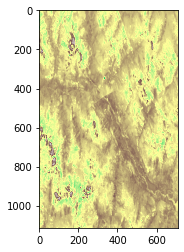

In [6]:
plt.imshow(NDMI, cmap="terrain")

In [13]:
# Brute write out

def Write_to_disk(comp_stack, out_name):
    #TODO: full COG writing: higher compression, overviews, tile size, nodata
    kwargs=({'driver':'GTiff',
             'height':comp_stack.shape[0],
             'width':comp_stack.shape[1],
             'count':comp_stack.shape[2],
             'dtype':comp_stack.dtype,
             'crs':crs,
             'transform':transform,
             'compress':'deflate'
            })
    with rio.open(out_name, 'w', **kwargs) as dst:
        dst.write(np.moveaxis(comp_stack, [0, 1, 2], [2, 1, 0]))
        
comp_stack = np.dstack([SAVI, MSAVI, NDMI, EVI, NBR, NBR2, TCB, TCG, TCW])
out_name = '/projects/bobafett/LandsatComposites/LandsatComposites/Landsat8_40349_comp_indices.tif'
Write_to_disk(comp_stack, out_name)